<a href="https://colab.research.google.com/github/skitw427/Layerwise-XAI/blob/main/notebook_demo/Layerwise_LRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install zennit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.1 MB/s eta 0:00:00


In [ ]:
import timm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import ast
import os

In [ ]:
model_name = "resnet18.a1_in1k"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = timm.create_model(model_name, pretrained=True)
model.eval()
model = model.to(device)

cuda


In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

image_dir = '276/'

image_tensors = []
for filename in os.listdir(image_dir):
    if filename.endswith('.JPEG'):
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image)
        image_tensors.append(image_tensor)

if image_tensors:
    input_tensor = torch.stack(image_tensors)
    print(f"Input tensor shape: {input_tensor.shape}")
else:
    print("No JPEG images found in the specified directory.")

input_tensor = input_tensor.to(device)
batch_size = input_tensor.shape[0]

Input tensor shape: torch.Size([6, 3, 224, 224])


In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [ ]:
from zennit.composites import EpsilonGammaBox
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.attribution import Gradient

canonizers = [SequentialMergeBatchNorm()]
composite = EpsilonGammaBox(low=-3., high=3., canonizers=canonizers)

target = torch.eye(1000, device=device)[[283]].repeat(batch_size, 1)

with Gradient(model=model, composite=composite) as attributor:
    out, relevance = attributor(input_tensor, target)

In [ ]:
import torch.nn.functional as F

# 모델의 출력 `out`에서 softmax를 계산하여 확률 분포로 변환
probs = F.softmax(out, dim=1)

# 각 입력에 대해 top-5 클래스의 인덱스와 확률 계산
top_k = 5
top_probs, top_indices = torch.topk(probs, top_k, dim=1)

# 결과 출력
for i in range(out.size(0)):  # 배치 크기만큼 반복
    print(f"Input {i + 1}:")
    print(out[i][283])
    for k in range(top_k):
        print(f"  Top-{k + 1} Class: {top_indices[i, k].item()}, Probability: {top_probs[i, k].item():.4f}")


Input 1:
tensor(-9.7088, device='cuda:0', grad_fn=<SelectBackward0>)
  Top-1 Class: 276, Probability: 0.5535
  Top-2 Class: 273, Probability: 0.1518
  Top-3 Class: 169, Probability: 0.0343
  Top-4 Class: 291, Probability: 0.0280
  Top-5 Class: 272, Probability: 0.0184
Input 2:
tensor(-13.5386, device='cuda:0', grad_fn=<SelectBackward0>)
  Top-1 Class: 276, Probability: 0.9953
  Top-2 Class: 275, Probability: 0.0019
  Top-3 Class: 104, Probability: 0.0004
  Top-4 Class: 273, Probability: 0.0003
  Top-5 Class: 274, Probability: 0.0001
Input 3:
tensor(-10.4985, device='cuda:0', grad_fn=<SelectBackward0>)
  Top-1 Class: 276, Probability: 0.8871
  Top-2 Class: 275, Probability: 0.0181
  Top-3 Class: 282, Probability: 0.0125
  Top-4 Class: 285, Probability: 0.0096
  Top-5 Class: 235, Probability: 0.0069
Input 4:
tensor(-10.2799, device='cuda:0', grad_fn=<SelectBackward0>)
  Top-1 Class: 276, Probability: 0.8682
  Top-2 Class: 212, Probability: 0.0357
  Top-3 Class: 170, Probability: 0.0112
 

torch.Size([6, 3, 224, 224])
(6, 224, 224)
-0.0037063889 0.047691986
3.6542367e-09 1.0


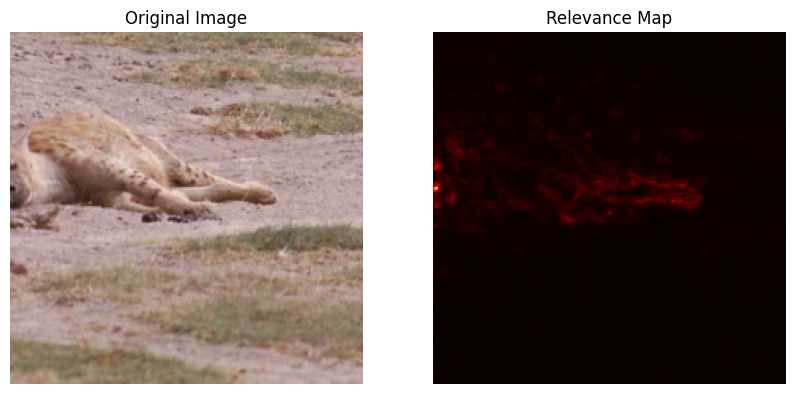

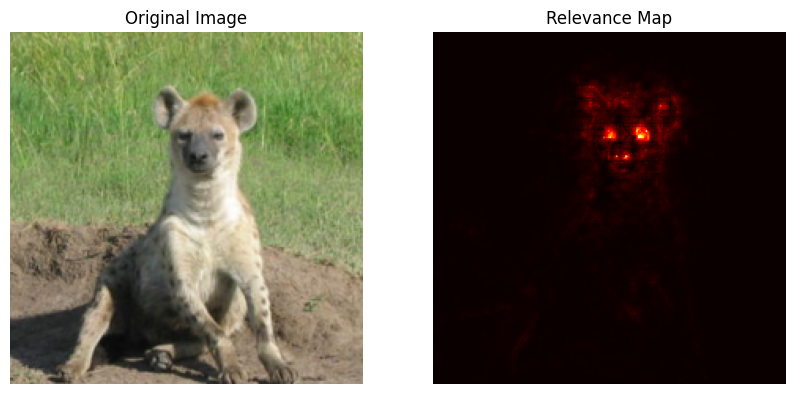

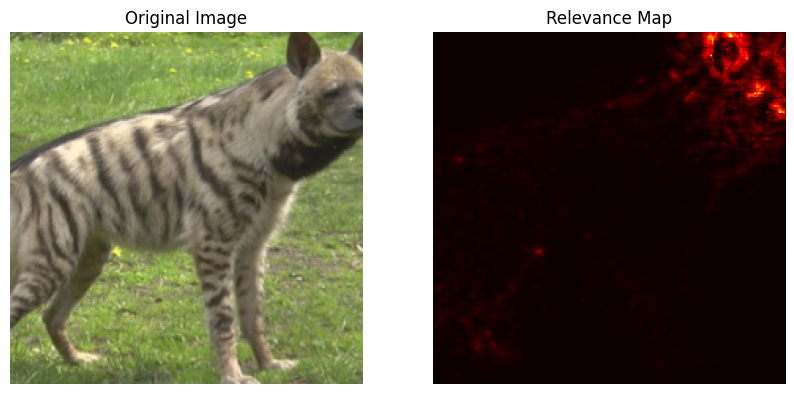

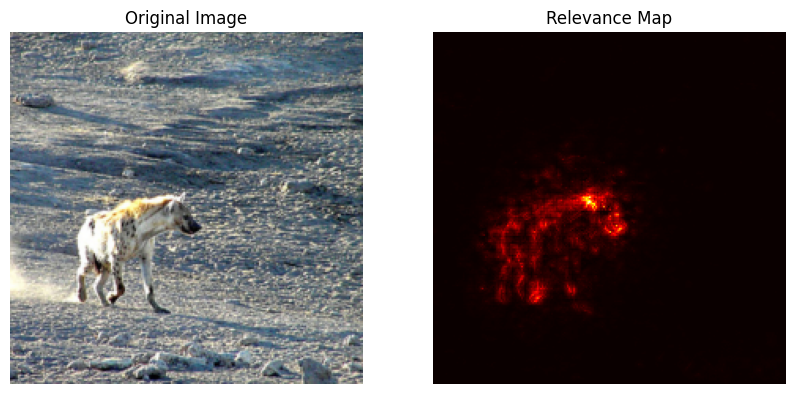

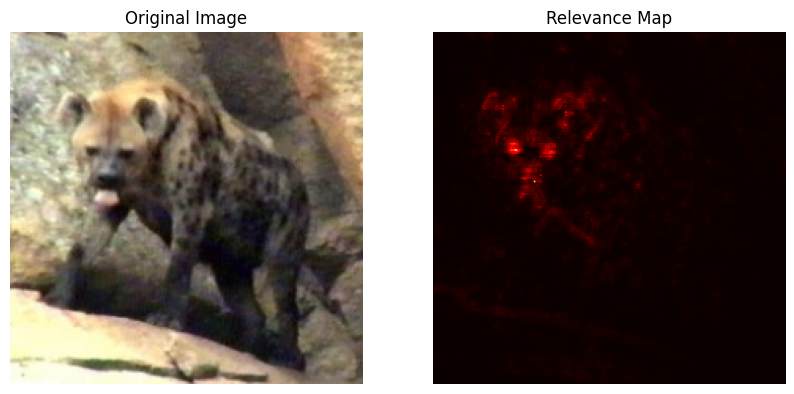

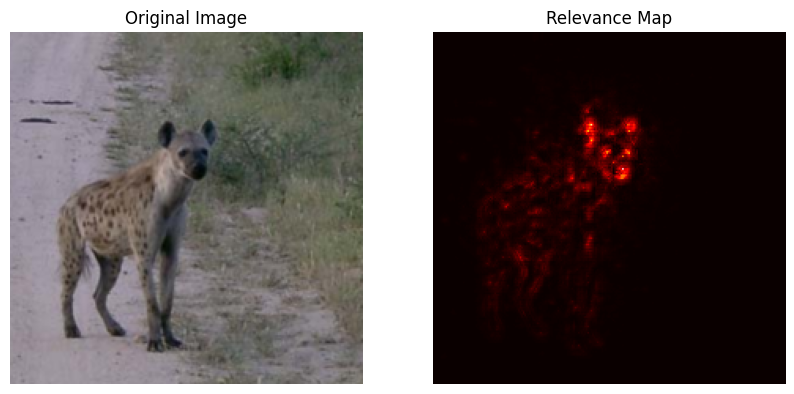

In [ ]:
import matplotlib.pyplot as plt

print(relevance.shape)

rel = relevance.sum(1).detach().cpu().numpy()
rgb_img = input_tensor.detach().cpu().numpy().copy()

print(rel.shape)

for b in range(rgb_img.shape[0]):
  for c in range(rgb_img.shape[1]):  # 채널(R/G/B)
    rgb_img[b, c, :, :] = rgb_img[b, c, :, :] * std[c] + mean[c]

img = rgb_img.transpose(0, 2, 3, 1)

print(rel.min(), rel.max())

relevance_norm = 'absolute'
# normalize between 0. and 1. given the specified strategy
if relevance_norm == 'symmetric':
    # 0-aligned symmetric relevance, negative and positive can be compared, the original 0. becomes 0.5
    amax = np.abs(rel).max((1, 2), keepdims=True)
    rel = (rel + amax) / 2 / amax
elif relevance_norm == 'absolute':
    # 0-aligned absolute relevance, only the amplitude of relevance matters, the original 0. becomes 0.
    rel = np.abs(rel)
    rel /= rel.max((1, 2), keepdims=True)
elif relevance_norm == 'unaligned':
    # do not align, the original minimum value becomes 0., the original maximum becomes 1.
    rmin = rel.min((1, 2), keepdims=True)
    rmax = rel.max((1, 2), keepdims=True)
    rel = (rel - rmin) / (rmax - rmin)

print(rel.min(), rel.max())

# 클래스 283의 값을 확인하고 rel 반전 적용
target_class_idx = 283
out_cpu = out.detach().cpu().numpy()

for i in range(batch_size):
    #if out_cpu[i, target_class_idx] < 0:  # 클래스 283 값이 음수일 때
    #    rel[i] = 1 - rel[i]  # 작은 값과 큰 값을 반대로 뒤집음

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img[i])
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(rel[i], cmap='hot', alpha=1)
    plt.title("Relevance Map")
    plt.axis('off')
    plt.show()

torch.Size([6, 3, 224, 224])
(6, 224, 224)
-0.0037063889 0.047691986
Positive relevance range: 0.0 0.99999976
Negative relevance range: 0.0 0.9999973


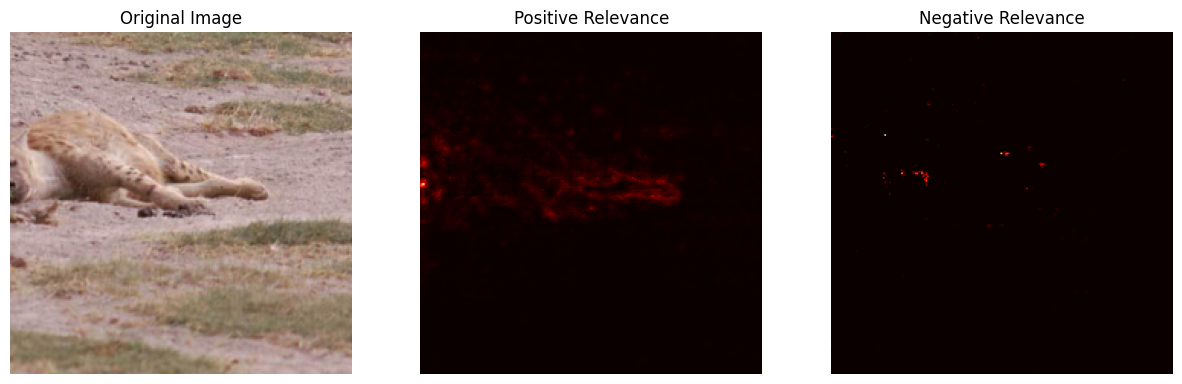

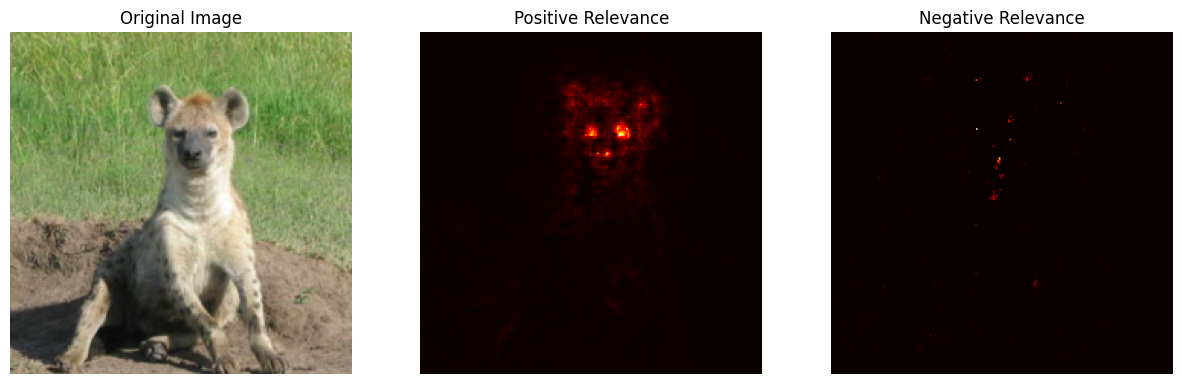

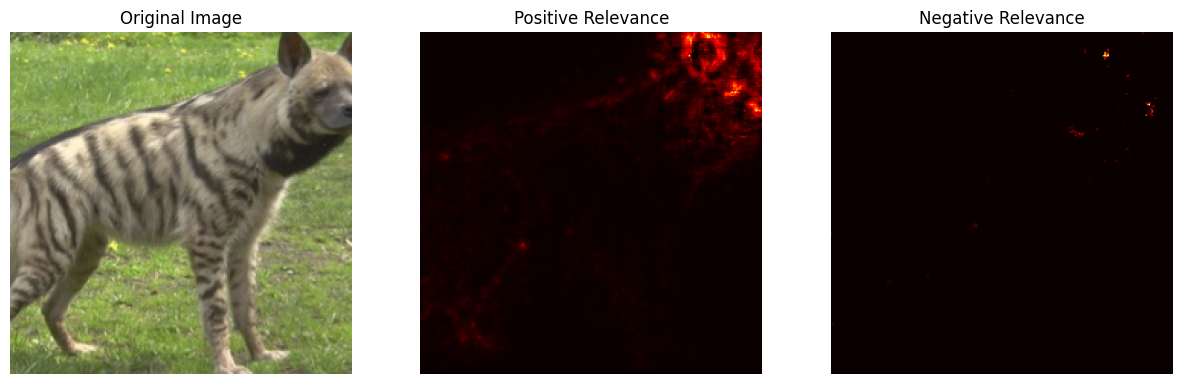

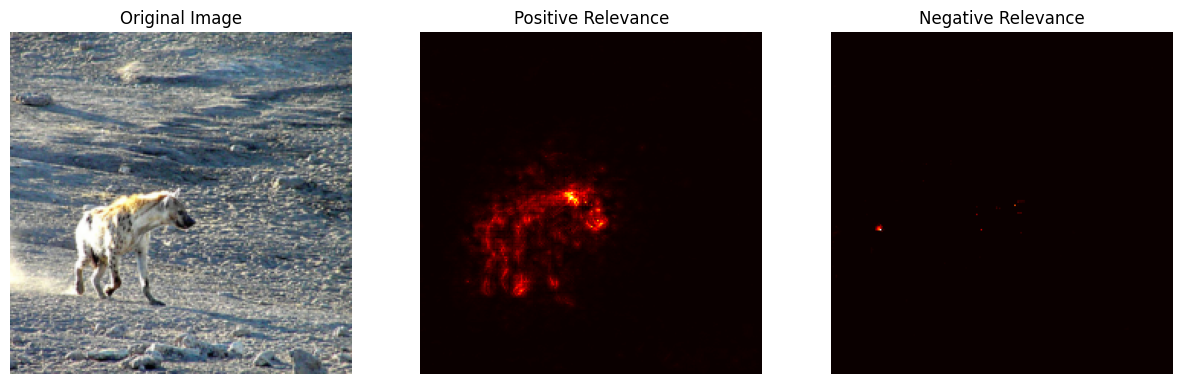

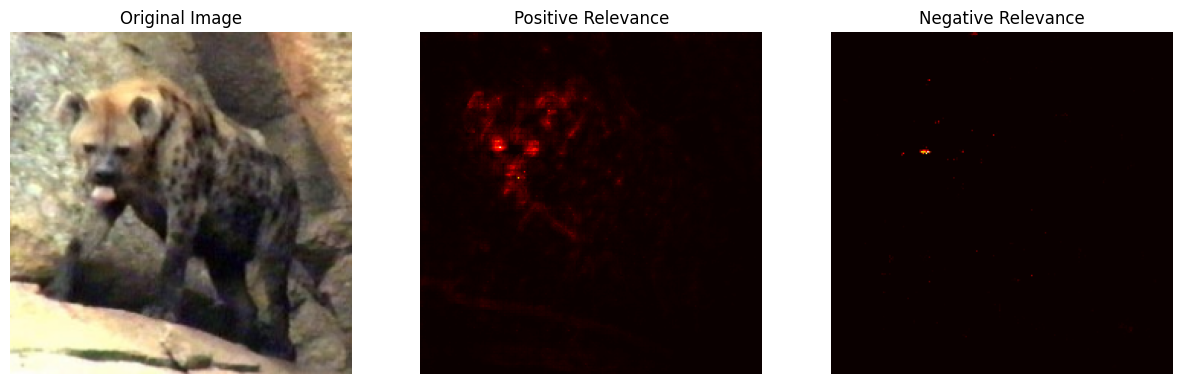

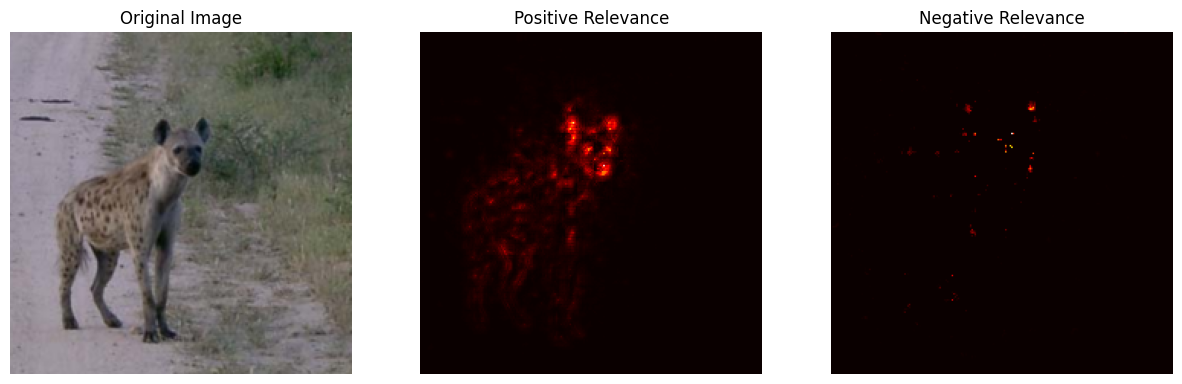

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print(relevance.shape)

rel = relevance.sum(1).detach().cpu().numpy()
rgb_img = input_tensor.detach().cpu().numpy().copy()

print(rel.shape)

# 역정규화하여 원본 이미지를 복원
for b in range(rgb_img.shape[0]):
    for c in range(rgb_img.shape[1]):  # 채널(R/G/B)
        rgb_img[b, c, :, :] = rgb_img[b, c, :, :] * std[c] + mean[c]

img = rgb_img.transpose(0, 2, 3, 1)

print(rel.min(), rel.max())

# 음수와 양수 값을 분리하여 각각 정규화
def normalize(data):
    data_min = data.min((1, 2), keepdims=True)
    data_max = data.max((1, 2), keepdims=True)
    return (data - data_min) / (data_max - data_min + 1e-8)  # 작은 값을 더해 나눗셈 방지

rel_pos = np.maximum(rel, 0)  # 양수 값만 추출
rel_neg = np.minimum(rel, 0)  # 음수 값만 추출
rel_neg = -rel_neg  # 음수 값을 양수로 변환

rel_pos = normalize(rel_pos)
rel_neg = normalize(rel_neg)

print("Positive relevance range:", rel_pos.min(), rel_pos.max())
print("Negative relevance range:", rel_neg.min(), rel_neg.max())

# 클래스 283의 값을 확인하고 rel 반전 적용
target_class_idx = 283
out_cpu = out.detach().cpu().numpy()

for i in range(batch_size):
    plt.figure(figsize=(15, 5))

    # 원본 이미지
    plt.subplot(1, 3, 1)
    plt.imshow(img[i])
    plt.title("Original Image")
    plt.axis('off')

    # 양수 relevance map
    plt.subplot(1, 3, 2)
    plt.imshow(rel_pos[i], cmap='hot', alpha=1)
    plt.title("Positive Relevance")
    plt.axis('off')

    # 음수 relevance map
    plt.subplot(1, 3, 3)
    plt.imshow(rel_neg[i], cmap='hot', alpha=1)
    plt.title("Negative Relevance")
    plt.axis('off')

    plt.show()


torch.Size([6, 3, 224, 224])
(6, 224, 224)


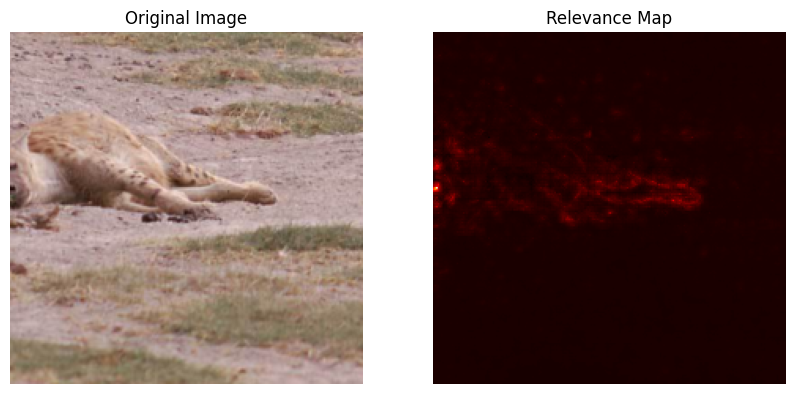

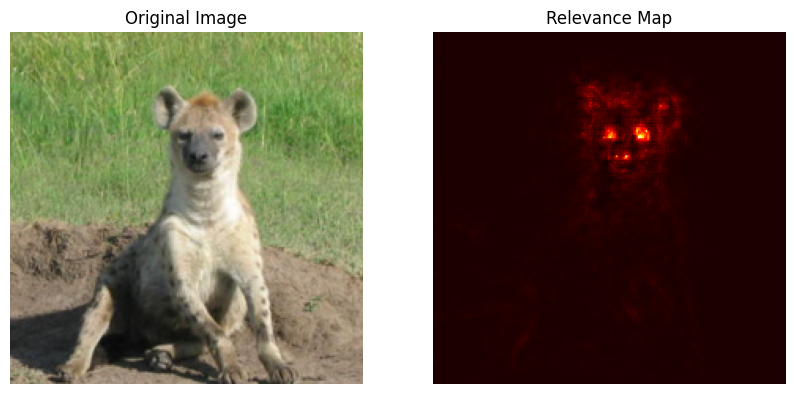

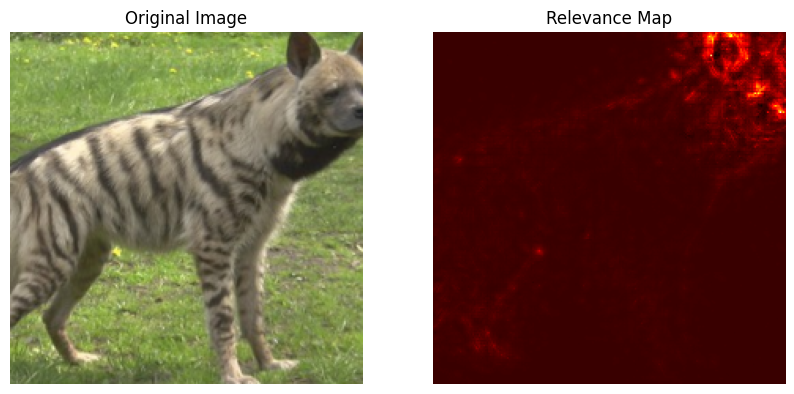

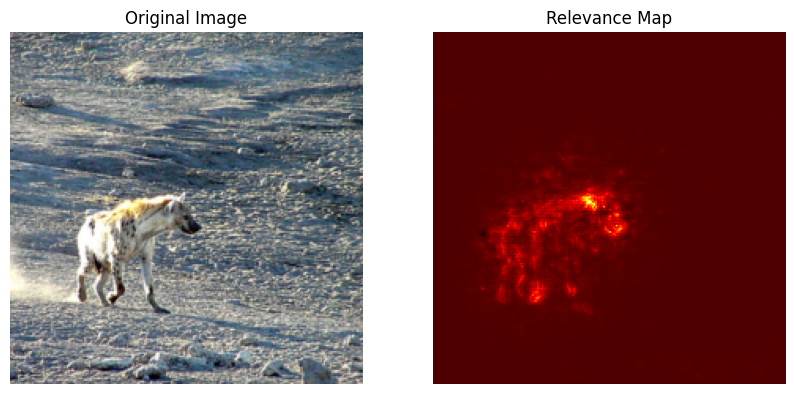

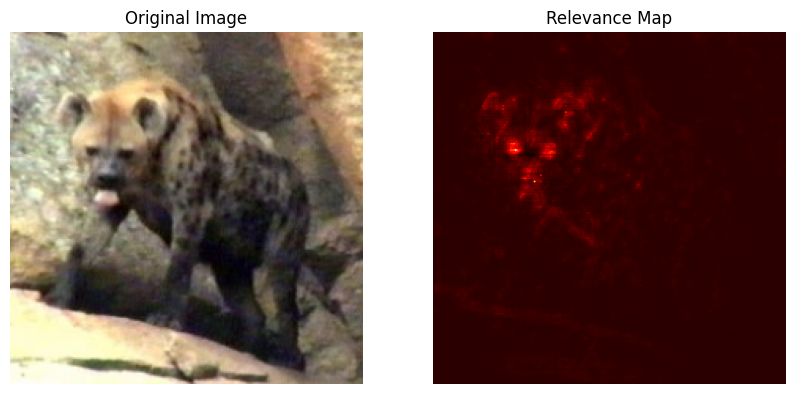

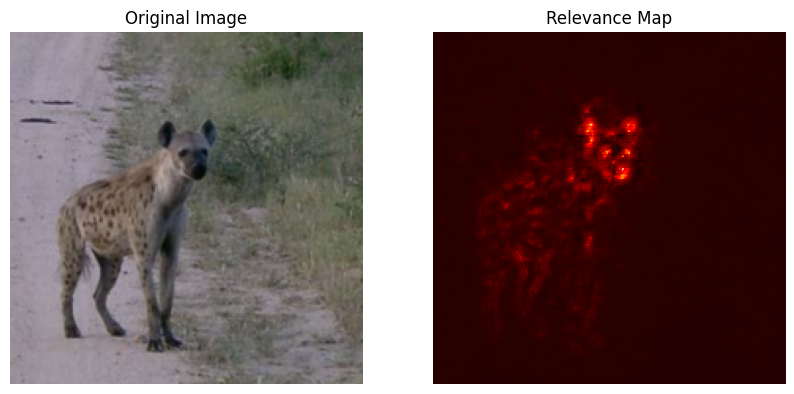

In [ ]:
import matplotlib.pyplot as plt

print(relevance.shape)

rel = relevance.sum(1).detach().cpu().numpy()
rgb_img = input_tensor.detach().cpu().numpy().copy()

print(rel.shape)

for b in range(rgb_img.shape[0]):
  for c in range(rgb_img.shape[1]):  # 채널(R/G/B)
    rgb_img[b, c, :, :] = rgb_img[b, c, :, :] * std[c] + mean[c]

img = rgb_img.transpose(0, 2, 3, 1)

relevance_norm = 'symmetric'
# normalize between 0. and 1. given the specified strategy
if relevance_norm == 'symmetric':
    # 0-aligned symmetric relevance, negative and positive can be compared, the original 0. becomes 0.5
    amax = np.abs(rel).max((1, 2), keepdims=True)
    rel = (rel + amax) / 2 / amax
elif relevance_norm == 'absolute':
    # 0-aligned absolute relevance, only the amplitude of relevance matters, the original 0. becomes 0.
    rel = np.abs(rel)
    rel /= rel.max((1, 2), keepdims=True)
elif relevance_norm == 'unaligned':
    # do not align, the original minimum value becomes 0., the original maximum becomes 1.
    rmin = rel.min((1, 2), keepdims=True)
    rmax = rel.max((1, 2), keepdims=True)
    rel = (rel - rmin) / (rmax - rmin)

for i in range(batch_size):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img[i])
    plt.title("Original Image")

    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(rel[i], cmap='hot', alpha=1)
    plt.title("Relevance Map")
    plt.axis('off')
    plt.show()

In [ ]:
model_name = "resnet18.a1_in1k"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = timm.create_model(model_name, pretrained=True)
model.eval()
original_model = model.to(device)

cuda


In [ ]:
import torch.nn as nn

original_model.eval()
data = input_tensor[0].unsqueeze(0).clone()
print(data.shape)

data = data.to(device)

layer4_outputs = []
def hook_fn(module, input, output):
    layer4_outputs.append(output.detach())

hook_handle = original_model.layer4.register_forward_hook(hook_fn)

# 원본 모델 추론
with torch.no_grad():
    o = original_model(data)
original_output = layer4_outputs[0]
hook_handle.remove()  # Hook 제거

print(o[0][283])

class TruncatedModelV1(nn.Module):
    def __init__(self, original_model, target_layer_name='layer4'):
        super().__init__()
        self.layers = []
        for name, module in original_model.named_children():
            self.layers.append(module)
            if name == target_layer_name:
                break
        self.truncated_model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.truncated_model(x)

truncated_v1 = TruncatedModelV1(original_model)

truncated_v1.to(device)

with torch.no_grad():
    output_v1 = truncated_v1(data)

# 결과 분석
def compare_tensors(a, b, name):
    print(f"[{name}]")
    print(f"Shape 일치: {a.shape == b.shape}")
    print(f"값 일치 (절대 오차 < 1e-5): {torch.allclose(a, b, atol=1e-5)}")
    print(f"최대 차이: {torch.max(torch.abs(a - b))}\n")

compare_tensors(original_output, output_v1, "Original vs V1")

print(original_output)
print(output_v1)

torch.Size([1, 3, 224, 224])
tensor(-9.7088, device='cuda:0')
[Original vs V1]
Shape 일치: True
값 일치 (절대 오차 < 1e-5): True
최대 차이: 0.0

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0573, 0.5621,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.8812, 0.8424, 0.2434,  ..., 0

In [ ]:
class TruncatedModelV1(nn.Module):
    def __init__(self, original_model, target_layer='layer4'):
        super().__init__()
        self.layers = []
        for name, module in original_model.named_children():
            self.layers.append(module)
            if name == target_layer:
                break
        self.truncated_model = nn.Sequential(*self.layers)

    def forward(self, x):
        features = self.truncated_model(x)

        gap = F.adaptive_avg_pool2d(features, (1, 1))
        gap = gap.squeeze(-1).squeeze(-1)

        gap_sum = gap.sum(dim=1).unsqueeze(1)

        return gap_sum

truncated_v1 = TruncatedModelV1(original_model, target_layer='layer4')

In [ ]:
model_name = "vgg19"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = timm.create_model(model_name, pretrained=True)
model.eval()
original_model = model.to(device)

cuda


In [ ]:
print(list(original_model.named_children()))

[('features', Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)


In [ ]:
class TruncatedModelV1(nn.Module):
    def __init__(self, original_model, target_index=36):
        super().__init__()
        self.layers = []
        truncated_features = []
        for idx, layer in enumerate(original_model.features):
            truncated_features.append(layer)
            if idx == target_index:
                break

        self.truncated_model = nn.Sequential(*truncated_features)
        # self.pre_logits = original_model.pre_logits

    def forward(self, x):
        features = self.truncated_model(x)
        # features = self.pre_logits(features)

        gap = F.adaptive_avg_pool2d(features, (1, 1))
        gap = gap.squeeze(-1).squeeze(-1)

        gap_sum = gap.sum(dim=1).unsqueeze(1)

        return gap_sum

truncated_v1 = TruncatedModelV1(original_model, target_index=20)

In [ ]:
print(truncated_v1)

TruncatedModelV1(
  (truncated_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3),

In [ ]:
for name, module in truncated_v1.named_modules():
    if isinstance(module, nn.Conv2d) and module.bias is None:
        # out_channels만큼 0으로 된 bias 파라미터를 생성
        module.bias = nn.Parameter(torch.zeros(module.out_channels, device=module.weight.device))

In [ ]:
from zennit.composites import EpsilonGammaBox
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.attribution import Gradient

canonizers = [SequentialMergeBatchNorm()]
# canonizers = []
composite = EpsilonGammaBox(low=-3., high=3., canonizers=canonizers)

target = torch.eye(1, device=device)[[0]].repeat(batch_size, 1)

with Gradient(model=truncated_v1, composite=composite) as attributor:
    out, relevance = attributor(input_tensor, target)

torch.Size([6, 3, 224, 224])
(6, 224, 224)
-0.0014972487 0.22370487
Positive relevance range: 0.0 0.99999994
Negative relevance range: 0.0 0.9999933


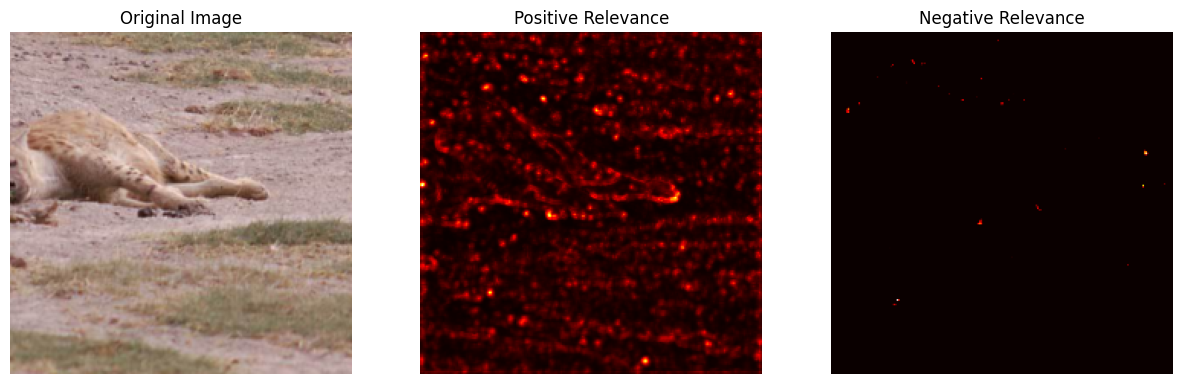

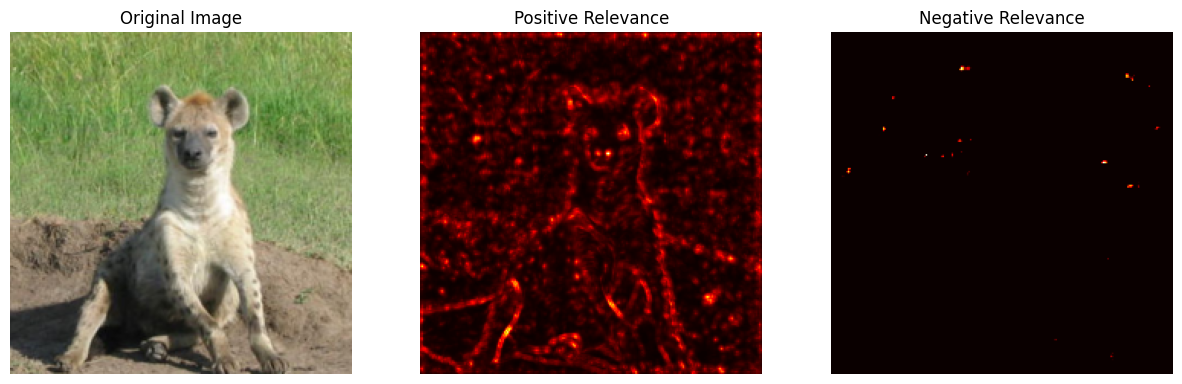

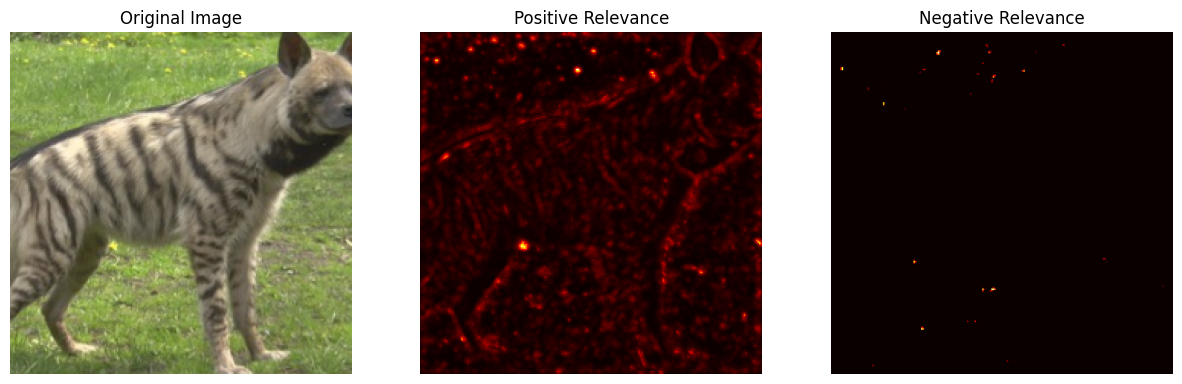

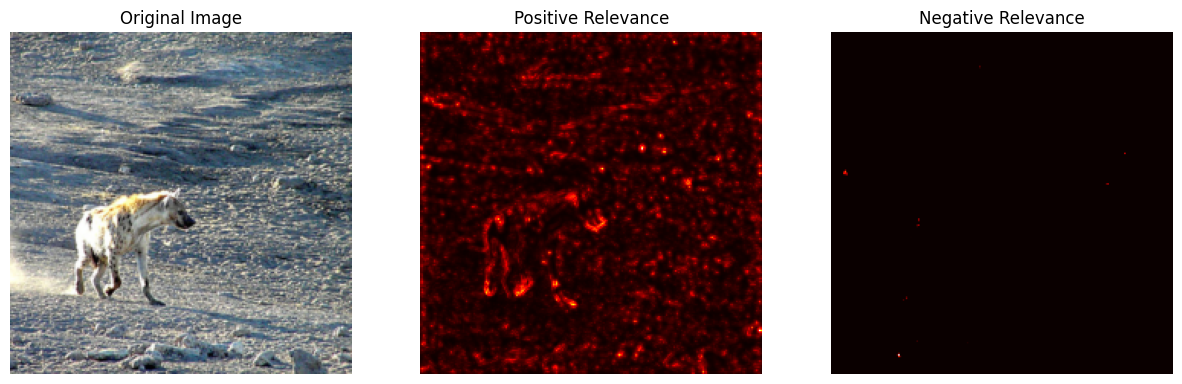

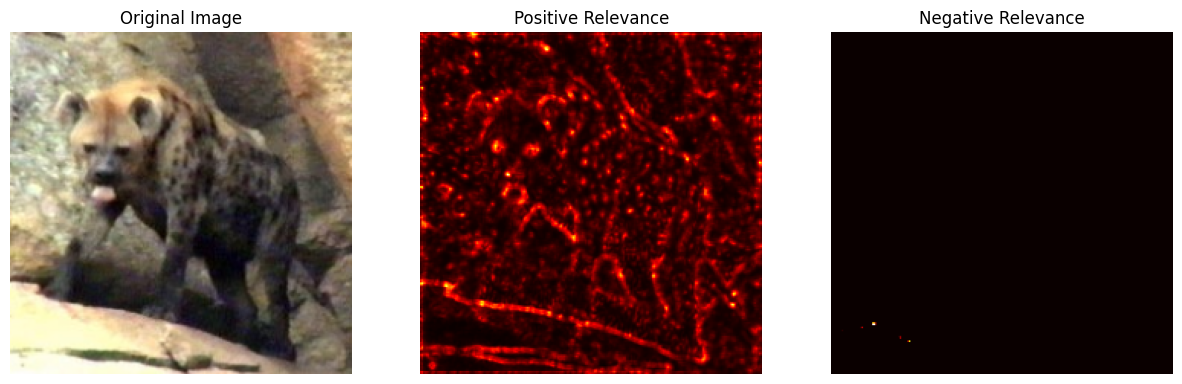

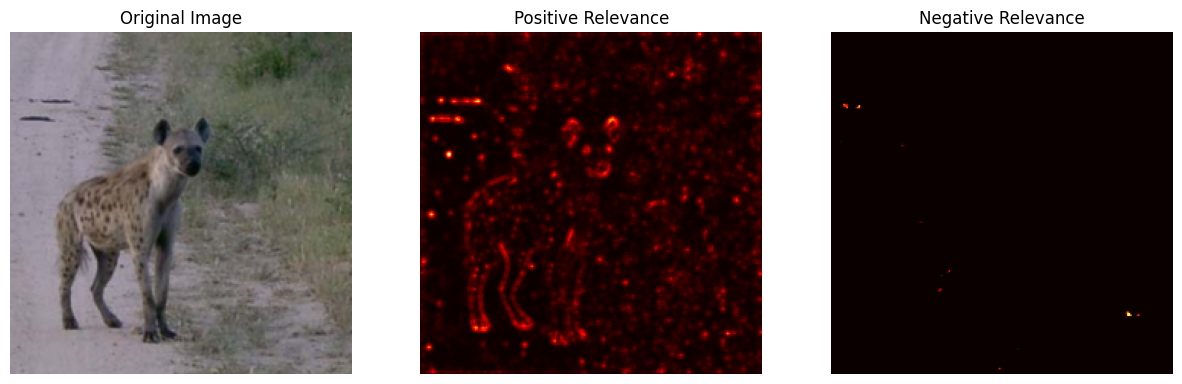

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print(relevance.shape)

rel = relevance.sum(1).detach().cpu().numpy()
rgb_img = input_tensor.detach().cpu().numpy().copy()

print(rel.shape)

# 역정규화하여 원본 이미지를 복원
for b in range(rgb_img.shape[0]):
    for c in range(rgb_img.shape[1]):  # 채널(R/G/B)
        rgb_img[b, c, :, :] = rgb_img[b, c, :, :] * std[c] + mean[c]

img = rgb_img.transpose(0, 2, 3, 1)

print(rel.min(), rel.max())

# 음수와 양수 값을 분리하여 각각 정규화
def normalize(data):
    data_min = data.min((1, 2), keepdims=True)
    data_max = data.max((1, 2), keepdims=True)
    return (data - data_min) / (data_max - data_min + 1e-8)  # 작은 값을 더해 나눗셈 방지

rel_pos = np.maximum(rel, 0)  # 양수 값만 추출
rel_neg = np.minimum(rel, 0)  # 음수 값만 추출
rel_neg = -rel_neg  # 음수 값을 양수로 변환

rel_pos = normalize(rel_pos)
rel_neg = normalize(rel_neg)

print("Positive relevance range:", rel_pos.min(), rel_pos.max())
print("Negative relevance range:", rel_neg.min(), rel_neg.max())

# 클래스 283의 값을 확인하고 rel 반전 적용
target_class_idx = 283
out_cpu = out.detach().cpu().numpy()

for i in range(batch_size):
    plt.figure(figsize=(15, 5))

    # 원본 이미지
    plt.subplot(1, 3, 1)
    plt.imshow(img[i])
    plt.title("Original Image")
    plt.axis('off')

    # 양수 relevance map
    plt.subplot(1, 3, 2)
    plt.imshow(rel_pos[i], cmap='hot', alpha=1)
    plt.title("Positive Relevance")
    plt.axis('off')

    # 음수 relevance map
    plt.subplot(1, 3, 3)
    plt.imshow(rel_neg[i], cmap='hot', alpha=1)
    plt.title("Negative Relevance")
    plt.axis('off')

    plt.show()
